# 标量、直方图和图像可视化

MindInsight可以将神经网络训练过程中的损失值标量、直方图、图像信息记录到日志文件中，通过可视化界面解析以供用户查看。

接下来是本次流程的体验过程。

## 整体流程

1. 准备环节。下载MNIST数据集，配置运行信息。

2. 数据处理。

3. 初始化LeNet网络。

4. 训练网络，使用`SummaryCollector`记录图像信息、损失值标量、权重梯度等参数，同时启动MindInsight服务，实时查看损失值、参数直方图和输入图像的变化。

5. 完成训练后，查看MindInsight看板中记录到的损失值标量、直方图、图像信息及标量对比信息。

6. 分别单独记录损失值标量、直方图、图像信息，查看展示结果，关闭MindInsight服务。

## 准备环节

### 下载数据集

本次流程用到MNIST数据集，MNIST数据集是一个手写的数据文件，数据库里的图像都是28x28的灰度图像，每个像素都是一个八位字节，包含了60000张训练图像和10000张测试图像，常被用作神经网络训练和测试任务的数据集。

执行下面一段代码下载MNIST数据集到当前工作目录，该段代码分为两部分：
1. 判断当前工作目录是否存在MNIST数据集目录，不存在则创建目录，存在则跳至[**数据预处理**](#数据预处理)。
2. 判断MNIST数据集目录是否存在MNIST数据集，不存在则下载MNIST数据集，存在则跳至[**数据预处理**](#数据预处理)。

In [1]:
import os
import urllib.request
from urllib.parse import urlparse
import gzip

def unzip_file(gzip_path):
    """
    unzip dataset file
    
    Args:
        gzip_path: Dataset file path
    """
    open_file = open(gzip_path.replace('.gz',''), 'wb')
    gz_file = gzip.GzipFile(gzip_path)
    open_file.write(gz_file.read())
    gz_file.close()


def download_dataset():
    """Download the dataset from http://yann.lecun.com/exdb/mnist/."""
    print("******Downloading the MNIST dataset******")
    train_path = "./MNIST_Data/train/"
    test_path = "./MNIST_Data/test/"
    train_path_check = os.path.exists(train_path)
    test_path_check = os.path.exists(test_path)
    if train_path_check == False and test_path_check ==False:
        os.makedirs(train_path)
        os.makedirs(test_path)
    train_url = {"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"}
    test_url = {"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}
    for url in train_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(train_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzip_file(file_name)
            os.remove(file_name)
    for url in test_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(test_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzip_file(file_name)
            os.remove(file_name)

download_dataset()

******Downloading the MNIST dataset******


下载数据集后，MNIST数据集目录结构如下所示。

```shell
$ tree MNIST_Data
MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
     ├── train-images-idx3-ubyte
     └── train-labels-idx1-ubyte
```

其中：
- `t10k-images-idx3-ubyte`文件为测试数据集图像文件。
- `t10k-labels-idx1-ubyte`文件为测试数据集图像标签。
- `train-images-idx3-ubyte`文件为训练数据集图像文件。
- `train-labels-idx1-ubyte`文件为测训练数据集图像标签。

### 配置运行信息

In [2]:
from mindspore import context


device_target = "CPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

## 数据处理

好的数据集可以有效提高训练精度和效率，在加载数据集前，会进行一些处理，增加数据的可用性和随机性。下面一段代码定义函数`create_dataset`来进行数据处理操作，并创建训练数据集`ds_train`。


In [3]:
import mindspore.dataset as ds
import mindspore.dataset.transforms.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.transforms.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """create dataset for train or test."""
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # define map operations
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # Bilinear mode
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # apply map operations on images
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  # 10000 as in LeNet train script
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ds_train = create_dataset(data_path="./MNIST_Data/train/")

### 抽取数据集图像

执行以下一段代码，抽取上步创建好的训练数据集`ds_train`中第一个`batch`的32张图像以及对应的标签数据进行展示，输出结果中`label`表示该图像的标签。

The 32 images with label of the first batch in ds_train are showed below:


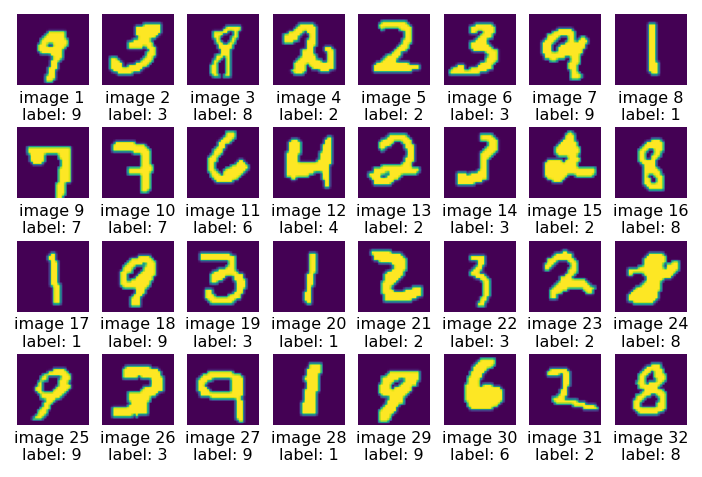

In [4]:
from matplotlib import pyplot as plt
import numpy as np

print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
batch_1 = ds_iterator.get_next()
batch_image = batch_1["image"]
batch_label = batch_1["label"]
plt.figure(dpi=144)
for i,image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = np.squeeze(image)
    plt.imshow(image)
    plt.title(f"image {i+1}\nlabel: {batch_label[i]}", y=-0.65, fontdict={"fontsize":8})
    plt.axis('off')    
plt.show()

## 网络初始化

在进行训练之前，需定义神经网络模型，本流程采用最简单的[LeNet卷积神经网络](http://yann.lecun.com/exdb/lenet/)。

LeNet网络不包括输入层的情况下，共有7层：2个卷积层、2个下采样层（池化层）、3个全连接层。每层都包含不同数量的训练参数。

In [5]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """weight initial for conv layer"""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


def fc_with_initialize(input_channels, out_channels):
    """weight initial for fc layer"""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


def weight_variable():
    """weight initial"""
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    """
    Lenet network

    Args:
        num_class (int): Num classes. Default: 10.
        channel (int): The number of image channel.

    Returns:
        Tensor, output tensor

    """
    def __init__(self, num_class=10, channel=1):
        super(LeNet5, self).__init__()
        self.num_class = num_class
        self.conv1 = conv(channel, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, self.num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## 记录标量、直方图、图像

本次体验中使用`SummaryCollector`来记录标量、直方图、图像信息。

在MindSpore中通过`Callback`机制，提供支持快速简易地收集损失值、参数权重、梯度等信息的`Callback`, 叫做`SummaryCollector`。详细的用法可以参考API文档中`mindspore.train.callback.SummaryCollector`。`SummaryCollector`使用方法如下： 

1. 为了记录损失值标量、直方图、图像信息，在下面一段代码中需要在`specified`参数中指定需要记录的信息。
    ```python
    specified={"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*", "collect_input_data": True}
    ```
    其中：
    - `"collect_metric"`为记录损失值标量信息。
    - `"histogram_regular"`为记录`conv1`层和`conv2`层直方图信息。
    - `"collect_input_data"`为记录图像信息。


2. 实例化`SummaryCollector`，并将其应用到`model.train`或者`model.eval`中。

    程序运行过程中将在本地`8080`端口自动启动MindInsight服务并自动遍历读取当前notebook目录下`summary_dir`子目录下所有日志文件、解析进行可视化展示。

### 导入模块

In [6]:
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.train.callback import SummaryCollector
from mindspore.train.serialization import load_checkpoint, load_param_into_net

### 执行训练

In [7]:
summary_base_dir = "./summary_dir"
network = LeNet5()
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
os.system(f"mindinsight start --summary-base-dir  {summary_base_dir} --port=8080")

# Init a SummaryCollector callback instance, and use it in model.train or model.eval
specified = {"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*", "collect_input_data": True}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_01", collect_specified_data=specified, collect_freq=1, keep_default_action=False)
print("============== Starting Training ==============")

# Note: dataset_sink_mode should be set to False, else you should modify collect freq in SummaryCollector
model.train(epoch=3, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=False)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_lenet-3_1875.ckpt")
load_param_into_net(network, param_dict)
ds_eval = create_dataset("./MNIST_Data/test/")
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=False)
print("============== {} ==============".format(acc))

============== Starting Training ==============
Epoch: [  1/  3], step: [    1/ 1875], loss: [2.2994/2.2994], time: [1687.2616]
Epoch: [  1/  3], step: [    2/ 1875], loss: [2.3039/2.3016], time: [49.0310]
Epoch: [  1/  3], step: [    3/ 1875], loss: [2.3018/2.3017], time: [46.0520]
Epoch: [  1/  3], step: [    4/ 1875], loss: [2.3052/2.3026], time: [40.3159]
Epoch: [  1/  3], step: [    5/ 1875], loss: [2.3015/2.3023], time: [38.1024]
Epoch: [  1/  3], step: [    6/ 1875], loss: [2.3037/2.3026], time: [38.1207]
Epoch: [  1/  3], step: [    7/ 1875], loss: [2.3072/2.3032], time: [33.6406]
Epoch: [  1/  3], step: [    8/ 1875], loss: [2.3027/2.3032], time: [34.5430]
Epoch: [  1/  3], step: [    9/ 1875], loss: [2.2994/2.3027], time: [41.9323]
Epoch: [  1/  3], step: [   10/ 1875], loss: [2.3030/2.3028], time: [34.3406]
 
...
 
Epoch: [  1/  3], step: [ 1864/ 1875], loss: [2.2996/2.3020], time: [29.2704]
Epoch: [  1/  3], step: [ 1865/ 1875], loss: [2.2926/2.3019], time: [31.7879]
Epoch:

# MindInsight看板

在本地浏览器中打开地址：`127.0.0.1:8080`，进入到可视化面板。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/mindinsight_panel.png)

在上图所示面板中可以看到`summary_01`日志文件目录，点击**训练看板**进入到下图所示的训练数据展示面板，该面板展示了标量数据、直方图和图像信息，并随着训练、测试的进行实时刷新数据，实时显示训练过程参数的变化情况。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/mindinsight_panel2.png)

## 标量可视化

标量可视化用于展示训练过程中标量的变化趋势情况，点击打开标量信息展示面板，该面板记录了迭代计算过程中的损失值标量信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/scalar_panel.png)

如下图的loss值标量趋势图。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/scalar.png)

上图展示了神经网络在训练过程中loss值的变化过程。横坐标是训练步骤，纵坐标是loss值。

图中右上角有几个按钮功能，从左到右功能分别是全屏展示，切换Y轴比例，开启/关闭框选，分步回退和还原图形。

- 全屏展示即全屏展示该标量曲线，再点击一次即可恢复。

- 切换Y轴比例是指可以将Y轴坐标进行对数转换。

- 开启/关闭框选是指可以框选图中部分区域，并放大查看该区域，可以在已放大的图形上叠加框选。

- 分步回退是指对同一个区域连续框选并放大查看时，可以逐步撤销操作。

- 还原图形是指进行了多次框选后，点击此按钮可以将图还原回原始状态。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/scalar_select.png)

上图展示的标量可视化的功能区，提供了根据选择不同标签，水平轴的不同维度和平滑度来查看标量信息的功能。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的标量信息。

- 水平轴：可以选择“步骤”、“相对时间”、“绝对时间”中的任意一项，来作为标量曲线的水平轴。

- 平滑度：可以通过调整平滑度，对标量曲线进行平滑处理。

- 标量合成：可以选中两条标量曲线进行合成并展示在一个图中，以方便对两条曲线进行对比或者查看合成后的图。
  标量合成的功能区与标量可视化的功能区相似。其中与标量可视化功能区不一样的地方，在于标签选择时，标量合成功能最多只能同时选择两个标签，将其曲线合成并展示。

## 直方图可视化


直方图用于将用户所指定的张量以直方图的形式展示。点击打开直方图展示面板，以直方图的形式记录了在迭代过程中所有层参数分布信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_panel.png)

如下图为`conv1`层参数分布信息，点击图中右上角，可以将图放大。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram.png)

下图为直方图功能区。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_func.png)

上图展示直方图的功能区，包含以下内容：

- 标签选择：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的直方图。

- 纵轴：可以选择步骤、相对时间、绝对时间中的任意一项，来作为直方图纵轴显示的数据。

- 视角：可以选择正视和俯视中的一种。正视是指从正面的角度查看直方图，此时不同步骤之间的数据会覆盖在一起。俯视是指偏移以45度角俯视直方图区域，这时可以呈现不同步骤之间数据的差异。

## 图像可视化

图像可视化用于展示用户所指定的图片。点击图像展示面板，展示了每个step进行处理的图像信息。

下图为展示`summary_01`记录的图像信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/image_panel.png)

通过滑动上图中的"步骤"滑条，查看不同步骤的图片。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/image_function.png)

上图展示图像可视化的功能区，提供了选择查看不同标签，不同亮度和不同对比度来查看图片信息。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的图片信息。

- 亮度调整：可以调整所展示的所有图片亮度。

- 对比度调整：可以调整所展示的所有图片对比度。

## 对比看板

对比看板可视用于多次训练之间的标量数据对比，为了展示对比看板，执行以下代码，在可视化面板中可以得到`summary_02`日志记录信息。

In [8]:
network = LeNet5()
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

# Init a SummaryCollector callback instance, and use it in model.train or model.eval
specified = {"collect_metric": True, "histogram_regular": "^conv1.*|^conv2.*", "collect_input_data": True}
summary_collector = SummaryCollector(summary_dir="./summary_dir/summary_02", collect_specified_data=specified, collect_freq=1, keep_default_action=False)
print("============== Starting Training ==============")

# Note: dataset_sink_mode should be set to False, else you should modify collect freq in SummaryCollector
model.train(epoch=3, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor(), summary_collector], dataset_sink_mode=False)
print("============== Starting Testing ==============")
param_dict = load_checkpoint("checkpoint_lenet_1-3_1875.ckpt")
load_param_into_net(network, param_dict)
ds_eval = create_dataset("./MNIST_Data/test/")
acc = model.eval(ds_eval, callbacks=summary_collector, dataset_sink_mode=False)
print("============== {} ==============".format(acc))

============== Starting Training ==============
Epoch: [  1/  3], step: [    1/ 1875], loss: [2.3063/2.3063], time: [843.7560]
Epoch: [  1/  3], step: [    2/ 1875], loss: [2.3044/2.3054], time: [36.1555]
Epoch: [  1/  3], step: [    3/ 1875], loss: [2.3081/2.3063], time: [32.8023]
Epoch: [  1/  3], step: [    4/ 1875], loss: [2.2985/2.3043], time: [32.3036]
Epoch: [  1/  3], step: [    5/ 1875], loss: [2.3014/2.3037], time: [28.8267]
Epoch: [  1/  3], step: [    6/ 1875], loss: [2.2961/2.3025], time: [34.9813]
Epoch: [  1/  3], step: [    7/ 1875], loss: [2.3025/2.3025], time: [27.3423]
Epoch: [  1/  3], step: [    8/ 1875], loss: [2.3042/2.3027], time: [29.7358]
Epoch: [  1/  3], step: [    9/ 1875], loss: [2.2988/2.3022], time: [29.9909]
Epoch: [  1/  3], step: [   10/ 1875], loss: [2.3038/2.3024], time: [33.7939]
 
...
 
Epoch: [  1/  3], step: [ 1865/ 1875], loss: [2.3122/2.3020], time: [26.6666]
Epoch: [  1/  3], step: [ 1866/ 1875], loss: [2.3070/2.3020], time: [28.9464]
Epoch: 

点击MindInsight看板中的**对比看板**，打开对比看板，可以得到`summary_01`和`summary_02`标量对比信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/multi_scalars.png)

上图展示了多次训练之间的标量曲线对比效果，横坐标是训练步骤，纵坐标是标量值。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/multi_scalars_select.png)

上图展示的对比看板可视的功能区，提供了根据选择不同训练或标签，水平轴的不同维度和平滑度来进行标量对比的功能。

- 训练：提供了对所有训练进行多项选择的功能，用户可以通过勾选或关键字筛选所需的训练。

- 标签：提供了对所有标签进行多项选择的功能，用户可以通过勾选所需的标签，查看对应的标量信息。

- 水平轴：可以选择“步骤”、“相对时间”、“绝对时间”中的任意一项，来作为标量曲线的水平轴。

- 平滑度：可以通过调整平滑度，对标量曲线进行平滑处理。

## 单独记录数据

以上流程为整体展示Summary算子能记录到的所有数据，也可以单独记录关心的数据，以降低性能开销和日志文件大小。

此处利用[**对比看板**](#对比看板)中的代码，为了排除前次训练对MindInsight展示结果的影响，在进行以下每个步骤之前先删除当前notebook根目录下的`summary_dir/summary_02`目录，配置完`specified`参数后执行[**对比看板**](#对比看板)中的代码，在MindInsight看板中查看结果。

### 单独记录损失值标量

配置`specified`参数为：

```python
specified={"collect_metric": True}
```

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/loss_scalar_only.png)

在MindInsight面板中，如上图所示，只展示了损失值标量信息。

### 单独记录参数分布直方图

配置`specified`参数为：

```python
specified = {"histogram_regular": "^conv1.*|^conv2.*|fc1.*|fc2.*|fc3.*"}
```

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_only.png)

在MindInsight面板中，如上图所示，只展示了参数直方图信息。

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/histogram_only_all.png)

点击进入直方图面板，如上图所示，展示了`conv1`、`conv2`、`fc1`、`fc2`、`fc3`等各层的权重、参数信息。

### 单独记录图像

配置`specified`参数为：

```python
specified = {"collect_input_data": True}
```

![](https://gitee.com/mindspore/docs/raw/master/tutorials/notebook/mindinsight/images/image_only.png)

在MindInsight面板中，如上图所示，只展示了输入图像信息。

## 关闭MindInsight服务

在终端命令行中执行以下代码关闭MindInsight服务。

```shell
mindinsight stop --port 8080
```

## 注意事项和规格

- 为了控制列出summary列表的用时，MindInsight最多支持发现999个summary列表条目。

- 为了控制内存占用，MindInsight对标签（tag）数目和步骤（step）数目进行了限制：

    - 每个训练看板的最大标签数量为300个标签。标量标签、图片标签、计算图标签、参数分布图（直方图）标签的数量总和不得超过300个。特别地，每个训练看板最多有10个计算图标签。当实际标签数量超过这一限制时，将依照MindInsight的处理顺序，保留最近处理的300个标签。

    - 每个训练看板的每个标量标签最多有1000个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。

    - 每个训练看板的每个图片标签最多有10个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    
    - 每个训练看板的每个参数分布图（直方图）标签最多有50个步骤的数据。当实际步骤的数目超过这一限制时，将对数据进行随机采样，以满足这一限制。
    
- 出于性能上的考虑，MindInsight对比看板使用缓存机制加载训练的标量曲线数据，并进行以下限制：
    
    - 对比看板只支持在缓存中的训练进行比较标量曲线对比。
    
    - 缓存最多保留最新（按修改时间排列）的15个训练。
    
    - 用户最多同时对比5个训练的标量曲线。

## 总结

本次体验流程为完整的MindSpore深度学习及MindInsight可视化展示的过程，包括了下载数据集及预处理过程，构建网络、损失函数和优化器过程，生成模型并进行训练、验证的过程，以及启动MindInsight服务进行训练过程可视化展示。读者可以基于本次体验流程构建自己的网络模型进行训练，并使用`SummaryCollector`记录关心的数据，然后在MindInsight服务看板中进行可视化展示，根据MindInsight服务中展示的结果调整相应的参数以提高训练精度。

以上便完成了标量、直方图和图像可视化的体验，我们通过本次体验全面了解了MindSpore执行训练的过程和MindInsight在标量、直方图和图像可视化的应用，理解了如何使用`SummaryColletor`记录训练过程中的标量、直方图和图像数据。